# Setup

In [1]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1278
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278


# Three node network

In [2]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

In [3]:
function additive_noise!(du,u,p,t)
    s,g,b,ϕ = p
    for i = 1:length(u)
        #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
        du[i] = ϕ 
    end
end

function network_model!(du,u,p,t)
    s,g,b,ϕ = p
    
    # Specifying task within the model to avoid adding it as a parameter in p
    ts = 1:1:Tmax
    task = repeat([0.0], 100)
    task[4] = 1 #without impulse it'd be "resting state"
    I = LinearInterpolation(ts, task, extrapolation_bc = 0)
    
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + b*I(t)
    end
end

network_model! (generic function with 1 method)

In [4]:
num_nodes = 3
u0 = repeat([0.0], num_nodes)
Tmax = 100.0
tspan = (0,Tmax)

W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]
dt = 0.5

# s = 0.3
# g = 0.7
# b = 0.5
# ϕ = 0.1

p = [0.3, 0.7, 0.5, 0.01]

prob_sde = SDEProblem(network_model!,additive_noise!,u0,tspan,p)


SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

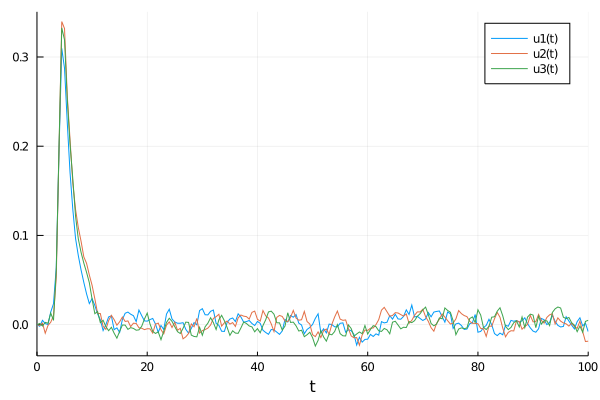

In [5]:
sol = solve(prob_sde, dt=dt, adaptive=false)
plot(sol)

Note: If you don't turn off adaptive step size then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control)

In [6]:
ensembleprob = EnsembleProblem(prob_sde)
data = solve(ensembleprob, SOSRI(), trajectories=100, dt=dt, adaptive=false)

EnsembleSolution Solution of length 100 with uType:
RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SOSRI,StochasticDiffEq.LinearInterpol

In [18]:
# EnsembleSummary(data)

In [24]:
Turing.setadbackend(:forwarddiff)
@model function fit_nmm(data, prob)
    σ ~ InverseGamma(2,3)
    ϕ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    s ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    g ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    b ~ truncated(Normal(0.0,1.0),-3.0,3.0)

    p = [s,g,b,ϕ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i],σ) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [25]:
model = fit_nmm(data, prob_sde)

DynamicPPL.Model{var"#3#4",(:data, :prob),(),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SO

In [ ]:
@time chain = sample(model, NUTS(), 100)

In [ ]:
# @time chain = sample(model, NUTS(), MCMCThreads(), 1000, 4)

In [ ]:
plot(chain)